# Stock Price Prediction Model

## Dependencies

### Library Installation (if needed)

In [85]:
#! pip install -Ur requirements.txt

### Importing Required Libraries

In [86]:
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np
import pickle
import gradio as gr
import ast
import warnings
from methods.model_methods import *
from datetime import datetime
from tqdm import tqdm
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=SyntaxWarning)

### Variables

In [87]:
symbol_list = input("Symbols: ('simple', 'filtered' or 'all')") # 'simple' or 'all'. simple are the tickers from the screener notebook and all are all of the tickers in 'filtered_tickers'. You may also an 'Int' to get a % amount of random tickers from 'all'
if symbol_list:
    build_new_dataset = True
else:
    build_new_dataset = False
    symbol_list = 'filtered'
minimum_feature_threshold = 0.6
outlier = 3
train_new_model = {'True': True, 'False': False}.get(input('Train new models? (Bool)'))
debugging = {'True': True, 'False': False}.get(input('Debug? (Bool)'))

In [88]:
symbols = pd.read_csv('../data/tickers/simple_tickers.csv')['Ticker'].tolist()
if symbol_list == 'filtered':
    symbols = symbols + pd.read_csv('../data/tickers/model_filtered_tickers.csv')['Ticker'].tolist()
elif symbol_list == 'all':
    symbols = symbols + pd.read_csv('../data/tickers/tickers.csv')['Ticker'].tolist()
elif symbol_list.isdigit():
    all_symbols = pd.read_csv('../data/tickers/tickers.csv')['Ticker'].tolist()
    num_symbols = max(1, round(len(all_symbols) * (int(symbol_list) / 100)))  
    symbols = symbols + pd.read_csv("../data/tickers/model_filtered_tickers.csv")["Ticker"].tolist()
    symbols = symbols + np.random.choice(all_symbols, num_symbols, replace=False).tolist()
symbols = pd.Series(symbols).unique()

## Data Preparation

#### Test load

In [89]:
test_stock = Stock("MSFT").get_df_financials()
if debugging:
    display(test_stock)

,Ticker,Name,Date,Earn Index,Sector,Industry,Price,3M Future Change,TaxEffectOfUnusualItems,TaxRateForCalcs,...,RawMaterials,Receivables,AccountsReceivable,AllowanceForDoubtfulAccountsReceivable,GrossAccountsReceivable,CashCashEquivalentsAndShortTermInvestments,OtherShortTermInvestments,CashAndCashEquivalents,CashEquivalents,CashFinancial
0,MSFT,Microsoft Corporation,2025-03-31,0,Technology,Software - Infrastructure,374.087158,NaN,69660000.0,0.180,...,3.270000e+08,5.170000e+10,5.170000e+10,-695000000.0,5.239500e+10,7.961200e+10,5.078400e+10,2.882800e+10,1.814800e+10,1.068000e+10
1,MSFT,Microsoft Corporation,2024-12-31,1,Technology,Software - Infrastructure,419.196533,-0.091444,-203220000.0,0.180,...,3.450000e+08,4.818800e+10,4.818800e+10,-662000000.0,4.885000e+10,7.155100e+10,5.406900e+10,1.748200e+10,7.835000e+09,9.647000e+09
2,MSFT,Microsoft Corporation,2024-09-30,2,Technology,Software - Infrastructure,427.093536,-0.010736,57190000.0,0.190,...,4.880000e+08,4.414800e+10,4.414800e+10,-647000000.0,4.479500e+10,7.842900e+10,5.758900e+10,2.084000e+10,1.025200e+10,1.058800e+10
3,MSFT,Microsoft Corporation,2024-06-30,3,Technology,Software - Infrastructure,442.821350,-0.040628,-99918000.0,0.182,...,3.940000e+08,5.692400e+10,5.692400e+10,-830000000.0,5.775400e+10,7.553100e+10,5.721600e+10,1.831500e+10,6.744000e+09,1.157100e+10
5,MSFT,Microsoft Corporation,2023-06-30,5,Technology,Software - Infrastructure,334.775482,-0.070833,-2850000.0,0.190,...,7.090000e+08,4.868800e+10,4.868800e+10,-650000000.0,4.933800e+10,1.112560e+11,7.655200e+10,3.470400e+10,2.622600e+10,8.478000e+09
6,MSFT,Microsoft Corporation,2022-06-30,6,Technology,Software - Infrastructure,250.065308,-0.073301,43754000.0,0.131,...,1.144000e+09,4.426100e+10,4.426100e+10,-633000000.0,4.489400e+10,1.047490e+11,9.081800e+10,1.393100e+10,5.673000e+09,8.258000e+09


#### Download annual financial data

In [90]:
if build_new_dataset:
    df = pd.DataFrame()
    filtered_pd = pd.read_csv("../data/tickers/model_filtered_tickers.csv")
    for symbol in tqdm(symbols, smoothing=0):
        ticker_df = pd.DataFrame()
        ticker = yf.Ticker(symbol)
        stock = Stock(symbol)
        try:
            ticker_df = Stock(symbol).get_df_financials()
            if ticker_df.isna().sum().sum() < round(test_stock.shape[1] * minimum_feature_threshold):
                if symbol not in filtered_pd["Ticker"].tolist():
                    filtered_pd = pd.concat([filtered_pd, pd.DataFrame([{"Ticker": symbol}])])
                imputer = SimpleImputer()
                for column in ticker_df.columns.drop(["Ticker", "Name", "Date", "3M Future Change", "Sector", "Industry"]):
                    if not ticker_df[column].isna().all():
                        ticker_df[column] = imputer.fit_transform(ticker_df[[column]])
            else:
                if symbol in filtered_pd["Ticker"].tolist():
                    filtered_pd = filtered_pd[filtered_pd["Ticker"] != symbol]
                    if debugging:
                        print(f"Removed {symbol} from filtered tickers. Datapoints: {ticker_df.isna().sum().sum()}, Needed: {round(test_stock.shape[1] * minimum_feature_threshold)}")
                continue
            df = pd.concat([df, ticker_df], ignore_index=True)
        except Exception as error:
            if symbol in filtered_pd["Ticker"].tolist():
                filtered_pd = filtered_pd[filtered_pd["Ticker"] != symbol]
                if debugging:
                    print(f"Removed {symbol} from filtered tickers because an exception was raised \n {error}")
            else:
                if debugging:
                    print(f"{symbol}: exception raised: {error}")
            continue
    filtered_pd.to_csv("../data/tickers/model_filtered_tickers.csv", index=False)
    df.to_csv("../data/model_results/earnings_data.csv", index=False)
else:
    df = pd.read_csv("../data/model_results/earnings_data.csv")

### Short visualisation

In [91]:
if debugging:
    display(df)

,Ticker,Name,Date,Earn Index,Sector,Industry,Price,3M Future Change,TaxEffectOfUnusualItems,TaxRateForCalcs,...,LiabilitiesHeldforSaleNonCurrent,DuetoRelatedPartiesNonCurrent,PolicyholderBenefitsGross,PolicyholderBenefitsCeded,DepletionIncomeStatement,OccupancyAndEquipment,ProfessionalExpenseAndContractServicesExpense,OtherNonInterestExpense,SecuritiesAmortization,ExciseTaxes
0,BAESY,BAE Systems PLC,2024-12-31,1.0,Industrials,Aerospace & Defense,56.118683,0.451540,-2.520000e+06,0.180000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BAESY,BAE Systems PLC,2023-12-31,3.0,Industrials,Aerospace & Defense,54.674278,0.216240,-5.567000e+07,0.190000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BAESY,BAE Systems PLC,2022-12-31,4.0,Industrials,Aerospace & Defense,39.349594,0.171293,7.744344e+07,0.158371,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BAESY,BAE Systems PLC,2021-12-31,5.0,Industrials,Aerospace & Defense,26.875683,0.257805,2.160000e+07,0.180000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,LLY,Eli Lilly and Company,2025-03-31,0.0,Healthcare,Drug Manufacturers - General,822.414185,NaN,-3.541868e+08,0.202000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4347,FM.TO,FIRST QUANTUM MINERALS LTD,2024-09-30,2.0,Basic Materials,Copper,18.440001,0.010846,-4.050000e+06,0.150000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4348,FM.TO,FIRST QUANTUM MINERALS LTD,2024-06-30,3.0,Basic Materials,Copper,17.969999,0.054535,-1.095000e+07,0.150000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4349,FM.TO,FIRST QUANTUM MINERALS LTD,2023-12-31,5.0,Basic Materials,Copper,11.050000,0.317647,-4.064000e+08,0.400000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4350,FM.TO,FIRST QUANTUM MINERALS LTD,2022-12-31,6.0,Basic Materials,Copper,28.116659,0.098268,4.048000e+07,0.220000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Impution and encoding

In [92]:
imputer = SimpleImputer()
for column in df.columns.drop(["Ticker", "Name", "Date", "Earn Index", "Price", "3M Future Change", "Sector", "Industry"]):
    df[column] = imputer.fit_transform(df[[column]])

le = LabelEncoder()
for column in ["Ticker", "Sector", "Industry"]:
    df[column] = df[column].astype(str)
    le.fit(df[column])
    df[column] = le.transform(df[column])

### Feature engineering

,Ticker,Name,Date,Earn Index,Sector,Industry,Price,3M Future Change,TaxEffectOfUnusualItems,TaxRateForCalcs,...,PolicyholderBenefitsGross,PolicyholderBenefitsCeded,DepletionIncomeStatement,OccupancyAndEquipment,ProfessionalExpenseAndContractServicesExpense,OtherNonInterestExpense,SecuritiesAmortization,ExciseTaxes,P/E,PE
0,56,BAE Systems PLC,2024-12-31,1.0,7,1,56.118683,0.451540,0.064474,-0.078708,...,0.0,9.752744e-16,9.122090e-15,0.0,1.651962e-16,-8.171130e-17,3.819977e-15,0.0,-5.979184,-5.979184
1,56,BAE Systems PLC,2023-12-31,3.0,7,1,54.674278,0.216240,-0.359883,0.032242,...,0.0,9.752744e-16,9.122090e-15,0.0,1.651962e-16,-8.171130e-17,3.819977e-15,0.0,-5.395299,-5.395299
2,56,BAE Systems PLC,2022-12-31,4.0,7,1,39.349594,0.171293,0.702914,-0.318681,...,0.0,9.752744e-16,9.122090e-15,0.0,1.651962e-16,-8.171130e-17,3.819977e-15,0.0,-3.211410,-3.211410
3,56,BAE Systems PLC,2021-12-31,5.0,7,1,26.875683,0.257805,0.257052,-0.078708,...,0.0,9.752744e-16,9.122090e-15,0.0,1.651962e-16,-8.171130e-17,3.819977e-15,0.0,-2.357277,-2.357277
4,422,Eli Lilly and Company,2025-03-31,0.0,6,29,822.414185,NaN,-2.743284,0.165382,...,0.0,9.752744e-16,9.122090e-15,0.0,1.651962e-16,-8.171130e-17,3.819977e-15,0.0,-119.111868,-119.111868
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4347,262,FIRST QUANTUM MINERALS LTD,2024-09-30,2.0,0,25,18.440001,0.010846,0.052258,-0.411558,...,0.0,9.752744e-16,9.122090e-15,0.0,1.651962e-16,-8.171130e-17,3.819977e-15,0.0,-0.830803,-0.830803
4348,262,FIRST QUANTUM MINERALS LTD,2024-06-30,3.0,0,25,17.969999,0.054535,-0.002832,-0.411558,...,0.0,9.752744e-16,9.122090e-15,0.0,1.651962e-16,-8.171130e-17,3.819977e-15,0.0,-0.775158,-0.775158
4349,262,FIRST QUANTUM MINERALS LTD,2023-12-31,5.0,0,25,11.050000,0.317647,-3.160162,2.362191,...,0.0,9.752744e-16,9.122090e-15,0.0,1.651962e-16,-8.171130e-17,3.819977e-15,0.0,-0.367853,-0.367853
4350,262,FIRST QUANTUM MINERALS LTD,2022-12-31,6.0,0,25,28.116659,0.098268,0.407792,0.365092,...,0.0,9.752744e-16,9.122090e-15,0.0,1.651962e-16,-8.171130e-17,3.819977e-15,0.0,-1.864638,-1.864638


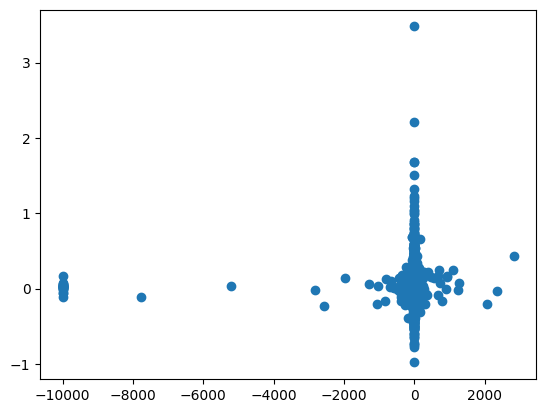

In [105]:
df["PE"] = df["Price"]/(df["BasicEPS"]*1000)
pe_limit = 10000
df["PE"] = df["PE"].apply(lambda x: pe_limit if x > pe_limit else x)
df["PE"] = df["PE"].apply(lambda x: -pe_limit if x < -pe_limit else x)
display(df)
plt.scatter(df["PE"].to_list(), df["3M Future Change"].to_list())
plt.show()

### Scaling

In [106]:
scaler = StandardScaler()
for column in df.columns.drop(["Ticker", "Name", "Date", "Earn Index", "Price", "3M Future Change", "Sector", "Industry"]):
    scaler.fit(df[[column]])
    df[column] = scaler.transform(df[[column]])

### Splitting

In [107]:
pred_data = df.loc[df["Earn Index"] == 0].copy()
test_data  = df.loc[df["Earn Index"] == 1].copy()
train_data = df.loc[~df["Earn Index"].isin([0, 1])].copy()

pred_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)
train_data.reset_index(drop=True, inplace=True)

if debugging:
    print('Prediction Data:')
    display(pred_data)
    print("Test Data:")
    display(test_data)
    print('Training Data:')
    display(train_data)

Prediction Data:


,Ticker,Name,Date,Earn Index,Sector,Industry,Price,3M Future Change,TaxEffectOfUnusualItems,TaxRateForCalcs,...,PolicyholderBenefitsGross,PolicyholderBenefitsCeded,DepletionIncomeStatement,OccupancyAndEquipment,ProfessionalExpenseAndContractServicesExpense,OtherNonInterestExpense,SecuritiesAmortization,ExciseTaxes,P/E,PE
0,422,Eli Lilly and Company,2025-03-31,0.0,6,29,822.414185,NaN,-2.743284,0.165382,...,-6.530724e-18,8.727275e-18,-7.078522e-18,6.530724e-18,-4.602579e-18,-9.873344e-18,6.034394e-18,1.632681e-18,0.07376,-0.072355
1,169,Danske Bank A/S,2025-03-31,0.0,5,11,225.100006,NaN,0.084594,0.609182,...,-6.530724e-18,8.727275e-18,-7.078522e-18,6.530724e-18,-4.602579e-18,-9.873344e-18,6.034394e-18,1.632681e-18,0.07376,0.103200
2,396,Jyske Bank A/S,2025-06-30,0.0,5,11,641.000000,NaN,0.084594,0.813252,...,-6.530724e-18,8.727275e-18,-7.078522e-18,6.530724e-18,-4.602579e-18,-9.873344e-18,6.034394e-18,1.632681e-18,0.07376,0.091041
3,508,"Netflix, Inc.",2025-06-30,0.0,1,34,1339.130005,NaN,0.084594,-0.522508,...,-6.530724e-18,8.727275e-18,-7.078522e-18,6.530724e-18,-4.602579e-18,-9.873344e-18,6.034394e-18,1.632681e-18,0.07376,0.193404
4,671,Scandinavian Tobacco Group A/S,2025-03-31,0.0,3,104,91.503189,NaN,-0.043583,0.476042,...,-6.530724e-18,8.727275e-18,-7.078522e-18,6.530724e-18,-4.602579e-18,-9.873344e-18,6.034394e-18,1.632681e-18,0.07376,0.074756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,117,CWLTH BANK FPO [CBA],2025-06-30,0.0,5,10,181.941757,NaN,-1.240646,1.297072,...,-6.530724e-18,8.727275e-18,-7.078522e-18,6.530724e-18,-4.602579e-18,-9.873344e-18,6.034394e-18,1.632681e-18,0.07376,0.108214
491,745,WORLDLINE,2025-06-30,0.0,9,95,3.585000,NaN,-0.940213,0.720132,...,-6.530724e-18,8.727275e-18,-7.078522e-18,6.530724e-18,-4.602579e-18,-9.873344e-18,6.034394e-18,1.632681e-18,0.07376,0.080723
492,402,Kinnevik AB ser. B,2025-06-30,0.0,5,6,83.680000,NaN,0.084594,-2.075807,...,-6.530724e-18,8.727275e-18,-7.078522e-18,6.530724e-18,-4.602579e-18,-9.873344e-18,6.034394e-18,1.632681e-18,0.07376,0.071205
493,740,WASTE CONNECTIONS INC,2025-06-30,0.0,7,111,253.423737,NaN,0.076422,0.742322,...,-6.530724e-18,8.727275e-18,-7.078522e-18,6.530724e-18,-4.602579e-18,-9.873344e-18,6.034394e-18,1.632681e-18,0.07376,0.061758


Test Data:


,Ticker,Name,Date,Earn Index,Sector,Industry,Price,3M Future Change,TaxEffectOfUnusualItems,TaxRateForCalcs,...,PolicyholderBenefitsGross,PolicyholderBenefitsCeded,DepletionIncomeStatement,OccupancyAndEquipment,ProfessionalExpenseAndContractServicesExpense,OtherNonInterestExpense,SecuritiesAmortization,ExciseTaxes,P/E,PE
0,56,BAE Systems PLC,2024-12-31,1.0,7,1,56.118683,0.451540,0.064474,-0.078708,...,-6.530724e-18,8.727275e-18,-7.078522e-18,6.530724e-18,-4.602579e-18,-9.873344e-18,6.034394e-18,1.632681e-18,0.07376,0.073184
1,422,Eli Lilly and Company,2024-12-31,1.0,6,29,767.409790,0.044842,-5.435903,-0.245133,...,-6.530724e-18,8.727275e-18,-7.078522e-18,6.530724e-18,-4.602579e-18,-9.873344e-18,6.034394e-18,1.632681e-18,0.07376,0.106572
2,169,Danske Bank A/S,2024-12-31,1.0,5,11,191.397659,0.176085,0.026390,0.620277,...,-6.530724e-18,8.727275e-18,-7.078522e-18,6.530724e-18,-4.602579e-18,-9.873344e-18,6.034394e-18,1.632681e-18,0.07376,0.082893
3,112,Carlsberg B A/S,2024-12-31,1.0,3,12,669.612610,0.309414,-0.705836,0.121002,...,-6.530724e-18,8.727275e-18,-7.078522e-18,6.530724e-18,-4.602579e-18,-9.873344e-18,6.034394e-18,1.632681e-18,0.07376,0.083455
4,396,Jyske Bank A/S,2025-03-31,1.0,5,11,551.000000,0.163339,0.084594,0.797797,...,-6.530724e-18,8.727275e-18,-7.078522e-18,6.530724e-18,-4.602579e-18,-9.873344e-18,6.034394e-18,1.632681e-18,0.07376,0.089987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
640,402,Kinnevik AB ser. B,2025-03-31,1.0,5,6,70.440002,0.187961,0.084594,-2.075807,...,-6.530724e-18,8.727275e-18,-7.078522e-18,6.530724e-18,-4.602579e-18,-9.873344e-18,6.034394e-18,1.632681e-18,0.07376,0.079740
641,428,LONDON STOCK EXCHANGE GROUP PLC,2024-12-31,1.0,5,37,11283.538086,0.027027,-0.232089,0.897652,...,-6.530724e-18,8.727275e-18,-7.078522e-18,6.530724e-18,-4.602579e-18,-9.873344e-18,6.034394e-18,1.632681e-18,0.07376,-0.816251
642,272,FRESNILLO PLC ORD USD0.50,2024-12-31,1.0,0,71,621.149841,0.533387,-0.280740,1.252692,...,-6.530724e-18,8.727275e-18,-7.078522e-18,6.530724e-18,-4.602579e-18,-9.873344e-18,6.034394e-18,1.632681e-18,0.07376,0.044353
643,740,WASTE CONNECTIONS INC,2025-03-31,1.0,7,111,278.991486,-0.091643,0.072871,0.453852,...,-6.530724e-18,8.727275e-18,-7.078522e-18,6.530724e-18,-4.602579e-18,-9.873344e-18,6.034394e-18,1.632681e-18,0.07376,0.060923


Training Data:


,Ticker,Name,Date,Earn Index,Sector,Industry,Price,3M Future Change,TaxEffectOfUnusualItems,TaxRateForCalcs,...,PolicyholderBenefitsGross,PolicyholderBenefitsCeded,DepletionIncomeStatement,OccupancyAndEquipment,ProfessionalExpenseAndContractServicesExpense,OtherNonInterestExpense,SecuritiesAmortization,ExciseTaxes,P/E,PE
0,56,BAE Systems PLC,2023-12-31,3.0,7,1,54.674278,0.216240,-0.359883,0.032242,...,-6.530724e-18,8.727275e-18,-7.078522e-18,6.530724e-18,-4.602579e-18,-9.873344e-18,6.034394e-18,1.632681e-18,0.07376,0.073935
1,56,BAE Systems PLC,2022-12-31,4.0,7,1,39.349594,0.171293,0.702914,-0.318681,...,-6.530724e-18,8.727275e-18,-7.078522e-18,6.530724e-18,-4.602579e-18,-9.873344e-18,6.034394e-18,1.632681e-18,0.07376,0.076745
2,56,BAE Systems PLC,2021-12-31,5.0,7,1,26.875683,0.257805,0.257052,-0.078708,...,-6.530724e-18,8.727275e-18,-7.078522e-18,6.530724e-18,-4.602579e-18,-9.873344e-18,6.034394e-18,1.632681e-18,0.07376,0.077843
3,422,Eli Lilly and Company,2024-09-30,2.0,6,29,879.216187,-0.125086,-8.598070,2.240146,...,-6.530724e-18,8.727275e-18,-7.078522e-18,6.530724e-18,-4.602579e-18,-9.873344e-18,6.034394e-18,1.632681e-18,0.07376,0.015381
4,422,Eli Lilly and Company,2024-06-30,3.0,6,29,897.254944,-0.029119,-0.848636,-0.340206,...,-6.530724e-18,8.727275e-18,-7.078522e-18,6.530724e-18,-4.602579e-18,-9.873344e-18,6.034394e-18,1.632681e-18,0.07376,-0.119729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3207,262,FIRST QUANTUM MINERALS LTD,2024-09-30,2.0,0,25,18.440001,0.010846,0.052258,-0.411558,...,-6.530724e-18,8.727275e-18,-7.078522e-18,6.530724e-18,-4.602579e-18,-9.873344e-18,6.034394e-18,1.632681e-18,0.07376,0.079807
3208,262,FIRST QUANTUM MINERALS LTD,2024-06-30,3.0,0,25,17.969999,0.054535,-0.002832,-0.411558,...,-6.530724e-18,8.727275e-18,-7.078522e-18,6.530724e-18,-4.602579e-18,-9.873344e-18,6.034394e-18,1.632681e-18,0.07376,0.079879
3209,262,FIRST QUANTUM MINERALS LTD,2023-12-31,5.0,0,25,11.050000,0.317647,-3.160162,2.362191,...,-6.530724e-18,8.727275e-18,-7.078522e-18,6.530724e-18,-4.602579e-18,-9.873344e-18,6.034394e-18,1.632681e-18,0.07376,0.080403
3210,262,FIRST QUANTUM MINERALS LTD,2022-12-31,6.0,0,25,28.116659,0.098268,0.407792,0.365092,...,-6.530724e-18,8.727275e-18,-7.078522e-18,6.530724e-18,-4.602579e-18,-9.873344e-18,6.034394e-18,1.632681e-18,0.07376,0.078477


### Labeling

In [108]:
training_columns = ["Ticker", "Earn Index", "Sector", "Industry", "PE"]
label_columns = ["3M Future Change"]
X_pred = pred_data[training_columns]
X_test = test_data[training_columns]
y_test = test_data[label_columns]
X_train = train_data[training_columns]
y_train = train_data[label_columns]
if debugging:
    print("X_pred:")
    display(X_pred)
    print("X_test:")
    display(X_test)
    print("y_test:")
    display(y_test)
    print("X_train:")
    display(X_train)
    print("y_train:")
    display(y_train)

X_pred:


,Ticker,Earn Index,Sector,Industry,PE
0,422,0.0,6,29,-0.072355
1,169,0.0,5,11,0.103200
2,396,0.0,5,11,0.091041
3,508,0.0,1,34,0.193404
4,671,0.0,3,104,0.074756
...,...,...,...,...,...
490,117,0.0,5,10,0.108214
491,745,0.0,9,95,0.080723
492,402,0.0,5,6,0.071205
493,740,0.0,7,111,0.061758


X_test:


,Ticker,Earn Index,Sector,Industry,PE
0,56,1.0,7,1,0.073184
1,422,1.0,6,29,0.106572
2,169,1.0,5,11,0.082893
3,112,1.0,3,12,0.083455
4,396,1.0,5,11,0.089987
...,...,...,...,...,...
640,402,1.0,5,6,0.079740
641,428,1.0,5,37,-0.816251
642,272,1.0,0,71,0.044353
643,740,1.0,7,111,0.060923


y_test:


,3M Future Change
0,0.451540
1,0.044842
2,0.176085
3,0.309414
4,0.163339
...,...
640,0.187961
641,0.027027
642,0.533387
643,-0.091643


X_train:


,Ticker,Earn Index,Sector,Industry,PE
0,56,3.0,7,1,0.073935
1,56,4.0,7,1,0.076745
2,56,5.0,7,1,0.077843
3,422,2.0,6,29,0.015381
4,422,3.0,6,29,-0.119729
...,...,...,...,...,...
3207,262,2.0,0,25,0.079807
3208,262,3.0,0,25,0.079879
3209,262,5.0,0,25,0.080403
3210,262,6.0,0,25,0.078477


y_train:


,3M Future Change
0,0.216240
1,0.171293
2,0.257805
3,-0.125086
4,-0.029119
...,...
3207,0.010846
3208,0.054535
3209,0.317647
3210,0.098268


## Model Training

In [109]:
if train_new_model:
    predictions = []

    model = RandomForestRegressor(
        n_estimators=500,
        verbose=True
    )
    model.fit(X_train, y_train.values.ravel())
    predictions.append(model.predict(X_test))

    model = MLPRegressor(
        hidden_layer_sizes=(500, 500),
        n_iter_no_change=30,
        learning_rate="adaptive",
        activation="tanh",
        early_stopping=True,
        verbose=True
    )
    model.fit(X_train, y_train.values.ravel())
    predictions.append(model.predict(X_test))

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    3.3s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    3.7s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


Iteration 1, loss = 4.10857215
Validation score: -0.768310
Iteration 2, loss = 0.30389161
Validation score: -11.989587
Iteration 3, loss = 0.09615944
Validation score: -2.937852
Iteration 4, loss = 0.03349872
Validation score: -0.231844
Iteration 5, loss = 0.02225371
Validation score: -0.118966
Iteration 6, loss = 0.02009376
Validation score: -0.066693
Iteration 7, loss = 0.01953014
Validation score: -0.035525
Iteration 8, loss = 0.01923065
Validation score: -0.028124
Iteration 9, loss = 0.01934957
Validation score: -0.055770
Iteration 10, loss = 0.01930020
Validation score: -0.045778
Iteration 11, loss = 0.01930873
Validation score: -0.055886
Iteration 12, loss = 0.01920947
Validation score: -0.029152
Iteration 13, loss = 0.01906062
Validation score: -0.024176
Iteration 14, loss = 0.01922320
Validation score: -0.054425
Iteration 15, loss = 0.01930599
Validation score: -0.049972
Iteration 16, loss = 0.01994488
Validation score: -0.028378
Iteration 17, loss = 0.01978886
Validation score

## Testing and benchmarking

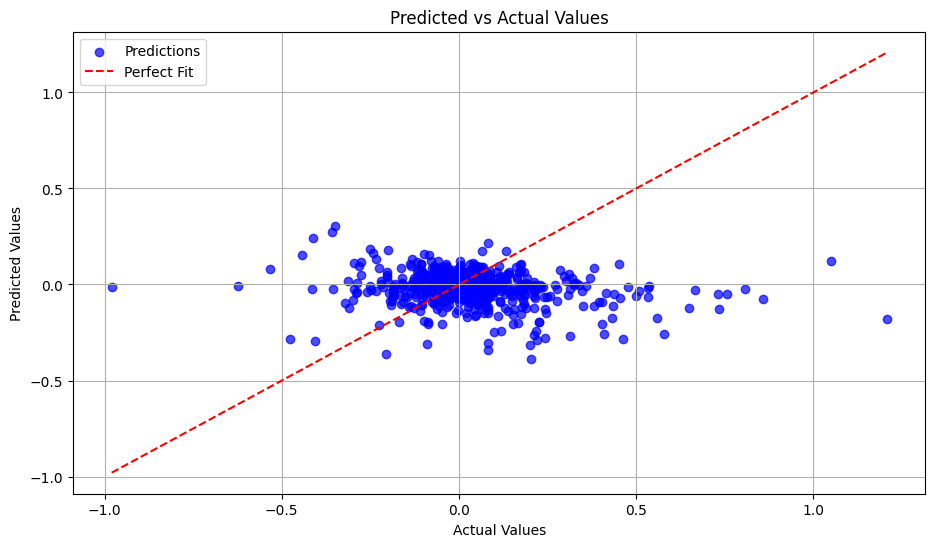

R²: -0.4611
MSE: 0.0507
MAE: 0.1477


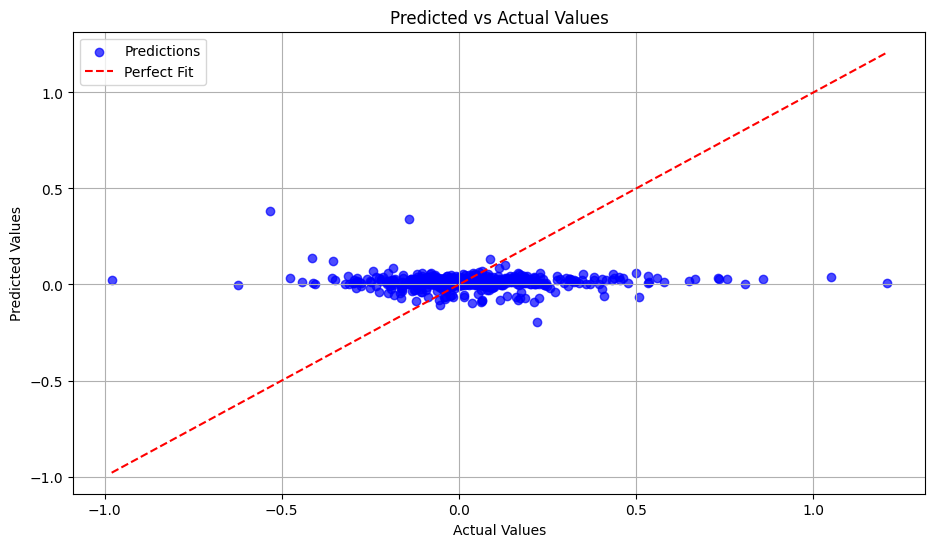

R²: -0.0631
MSE: 0.0369
MAE: 0.1224


In [110]:
if train_new_model:
    for y_pred in predictions:
        plt.figure(figsize=(11, 6))
        plt.scatter(y_test, y_pred, alpha=0.7, color='blue', label='Predictions')
        plt.plot([y_test.values.min(), y_test.values.max()], [y_test.values.min(), y_test.values.max()], 
            color='red', linestyle='--', label='Perfect Fit')
        plt.title(f'Predicted vs Actual Values')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.legend()
        plt.grid(True)
        plt.show()

        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        print(f'R²: {r2:.4f}')
        print(f'MSE: {mse:.4f}')
        print(f'MAE: {mae:.4f}')

### Log test results

In [ ]:
if train_new_model:
    test_results = pd.DataFrame({
        'R²': r2,
        'MSE': mse,
        'MAE': mae,
        'symbol_list': symbol_list,
        "iterations": iterations,
        'hidden_layer_sizes': [model.model.hidden_layer_sizes],
        'max_iter': model.model.max_iter,
        'n_iter_no_change': model.model.n_iter_no_change,
        'learning_rate': model.model.learning_rate,
        'learning_rate_init': model.model.learning_rate_init,
        'batch_size': model.model.batch_size,
        'tol': model.model.tol,
        'alpha': model.model.alpha,
        'shuffle': model.model.shuffle,
    })
    test_results.to_csv('../data/model_results/test_results.csv', mode='a', index=False)

    # save model as new best if results are better than the current one
    best_r2 = pd.read_csv('../data/model_results/best_model_results.csv').loc[0, 'R²']
    if r2 > best_r2:
        print(f'Old best R²: {best_r2}')
        print(f'New best R²: {r2}')
        print('Saving new best model...')
        test_results.to_csv('../data/model_results/best_model_results.csv', mode='w', index=False)
        with open('../models/best_model.pkl','wb') as f:
            pickle.dump(model,f)
        

NameError: name 'iterations' is not defined

## Predictions on latest data

In [ ]:
best_r2 = pd.read_csv('../data/model_results/best_model_results.csv').loc[0, 'R²']

with open('../models/best_model.pkl', 'rb') as f:
    model = pickle.load(f)
    print(f'Best model R²: {best_r2}')


FileNotFoundError: [Errno 2] No such file or directory: '../models/best_model.pkl'

In [ ]:
df_raw = pd.read_csv('../data/model_results/earnings_data.csv')

results = []
for i in range(len(X_pred)):
    y_pred = model.predict(X_pred.iloc[[i]])[0]
    y_pred_3m, y_pred_6m, y_pred_9m, y_pred_1y = y_pred
    avg = (y_pred_3m + y_pred_6m + y_pred_9m + y_pred_1y) / 4
    results.append({
        'Ticker': df_raw.loc[i*4, 'Ticker'],
        'Name': df_raw.loc[i*4, 'Name'],
        'mean (%)': avg * 100,
        '3m (%)': y_pred_3m * 100,
        '6m (%)': y_pred_6m * 100,
        '9m (%)': y_pred_9m * 100,
        '1y (%)': y_pred_1y * 100
    })

results_df = pd.DataFrame(results)
results_df

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- ExciseTaxes


In [ ]:
def predict_ticker(ticker_str):
    try:
        ticker_str = str(ticker_str).upper()
        ticker_str = ticker_str.replace("'", "")
        ticker_str = ticker_str.replace('"', "")
        row = results_df[results_df['Ticker'] == ticker_str]
        if row.empty:
            return (f"Not enough data for this stock at this moment \n Try another", "", "", "", "")
        row = row.iloc[0]
        return (
            f"{row['3m (%)']:.2f}",
            f"{row['6m (%)']:.2f}",
            f"{row['9m (%)']:.2f}",
            f"{row['1y (%)']:.2f}",
            f"{row['mean (%)']:.2f}",
        )
    except Exception as e:
        return (f"Error: {e}", "", "", "", "")

In [ ]:
iface = gr.Interface(
    fn=predict_ticker,
    inputs=gr.Textbox(label="Ticker e.g. 'TSLA' or 'NVDA'"),
    outputs=[
        gr.Textbox(label="3 Month Change Prediction (%)"),
        gr.Textbox(label="6 Month Change Prediction (%)"),
        gr.Textbox(label="9 Month Change Prediction (%)"),
        gr.Textbox(label="1 Year Change Prediction (%)"),
        gr.Textbox(label="Mean Change Prediction (%)"),
    ],
    title="Stock Price Prediction Model",
    description=" "
)

iface.launch(share=True)

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://d6f7567b4876962a6e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
